In [4]:
from pyrocko import io,model,trace,util
import os
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# data folder (response removed)
workdir='../'
datadir =  os.path.join(workdir,'DATA_VLP')

# events catalogue
catdir=os.path.join(workdir,'CAT')
catname=os.path.join(catdir,'catalogue_flegrei_VLP.pf')
target_events=model.load_events(catname)

# stations list
stationsdir=os.path.join(workdir,'META_DATA')
stationsname=os.path.join(stationsdir,'stations_flegrei_INGV_final_similarity.pf')
stations=model.load_stations(stationsname)

# figure dir
plotdir=os.path.join(workdir,'PLOTS/PAPER/SF1')

freq_min=0.09
freq_max=0.13

#dictionary for selected traces at selected stations
dict_traces = {key.station: [] for key in stations}
for station in dict_traces:
    dict_traces[station] = {key.name: [] for key in target_events}

#dictionary containing max amplitude registered at CPOZ for each event
dict_cpoz_max = {key.name: [] for key in target_events}

for targ_ev in target_events:   # loop each event
    event_name=targ_ev.name
    ev_dir = os.path.join(datadir, event_name)
    
    if not os.path.isdir(ev_dir):
        print(event_name, 'missing data dir', ev_dir)
    elif os.path.isdir(ev_dir):
        file_name = os.path.join(ev_dir,event_name + '.mseed' )
        traces = io.load(file_name)
        print(f'reading event: {event_name}')

        for tr in traces:   # normalize traces for each event relative to CPOZ
            if tr.channel=='HHZ' and tr.station=='CPOZ':
                tmp_trace_max= tr.copy()
                tmp_trace_max.lowpass(4,freq_max)
                tmp_trace_max.highpass(4,freq_min)
                tmp_trace_max.chop(tmp_trace_max.tmin+270, tmp_trace_max.tmin+450)
                max_cpoz=np.max(np.abs(tmp_trace_max.ydata) )
                dict_cpoz_max[event_name]=max_cpoz

        for tr in traces:
            if tr.channel=='HHZ':   # select HHZ channel
                #print('\nsearch!')
                for key in dict_traces:
                    #print(tr.channel,tr.station,'=?=',key)
                    if key== tr.station:    #  if target station is = to trace station
                        #print('yes!')
                        tmp_trace= tr.copy()
                        tmp_trace.lowpass(4,freq_max)
                        tmp_trace.highpass(4,freq_min)
                        tmp_trace.chop(tmp_trace.tmin+270, tmp_trace.tmin+450)
                        tmin_new = util.str_to_time('2000-01-01 00:00:0.000')
                        tmp_trace.shift(tmin_new - tmp_trace.tmin)
                        tmp_trace.ydata /= max_cpoz
                        dict_traces[tr.station][event_name].append(tmp_trace)

reading event: flegrei_2018_09_18_21_36_41
reading event: flegrei_2023_06_11_06_44_25
reading event: flegrei_2023_09_07_17_45_28
reading event: flegrei_2023_09_26_07_10_29
reading event: flegrei_2023_10_02_20_08_26
reading event: flegrei_2024_04_27_03_44_56
reading event: flegrei_2024_05_22_06_28_00
reading event: flegrei_2024_06_08_01_52_04
reading event: flegrei_2024_06_18_01_58_24
reading event: flegrei_2024_07_26_11_46_21
reading event: flegrei_2024_08_30_19_23_15
reading event: flegrei_2025_02_16_14_30_02
reading event: flegrei_2025_03_13_00_25_02


In [6]:
#dict_traces['CPOZ']['flegrei_2023_06_11_06_44_25'][0].snuffle()

In [7]:
# Check correlation
switch_check_correlation=False
if switch_check_correlation:
    st_corr='CPOZ'
    print(f'time shift at station {st_corr}')
    ref_tr=dict_traces[st_corr]['flegrei_2024_04_27_03_44_56'][0].copy()
    
    for ev in dict_traces[st_corr]:
        if dict_traces[st_corr][ev] != []:
            evtr = dict_traces[st_corr][ev][0].copy()
            tmp_corr=trace.correlate(ref_tr,evtr,mode='same')
    
            coef_max=np.max(tmp_corr.ydata)
            coef_min=np.min(tmp_corr.ydata)
            if coef_max>np.abs(coef_min):
                coef=coef_max
            else:
                coef=coef_min
            nt= np.where(tmp_corr.ydata==coef)[0][0]
            t=tmp_corr.tmin + nt*tmp_corr.deltat
    
            print(f'{ev} shifted of t : {t} s, coef : {coef}')
            tax=np.arange(tmp_corr.tmin,tmp_corr.tmax,tmp_corr.deltat)
            plt.figure()
            plt.title(f't : {t:4.4}, coeff : {coef:5.5}')
            plt.plot(tax[12000:18000],tmp_corr.ydata[12000:18000],'k',label=f'{ev[8:]}')
            #plt.plot(tax[24000:36000],tmp_corr.ydata[24000:36000],'k',label=f'{ev[8:]}')
            #plt.plot(tax,tmp_corr.ydata,'k',label=f'{ev[8:]}')
    
            plt.plot(t,coef,'oc')
            plt.legend(loc=1)


In [8]:
ref_tr=dict_traces['CPOZ']['flegrei_2024_04_27_03_44_56'][0].copy()

for ev in dict_traces['CPOZ']:
    evtr = dict_traces['CPOZ'][ev][0].copy()
    tmp_corr=trace.correlate(ref_tr,evtr,mode='same')

    coef_max=np.max(tmp_corr.ydata)
    coef_min=np.min(tmp_corr.ydata)
    if coef_max>np.abs(coef_min):
        coef=coef_max
    else:
        coef=coef_min
    nt= np.where(tmp_corr.ydata==coef)[0][0]
    t=tmp_corr.tmin + nt*tmp_corr.deltat
    print(f'{ev} shifted of t : {t} s, coef : {coef}')

    for station in dict_traces:
        if dict_traces[station][ev] != []:
            dict_traces[station][ev][0].shift(-t)        # align 'evtr' with 'ref_tr'
            if coef<0:
                dict_traces[station][ev][0].ydata *= -1


flegrei_2018_09_18_21_36_41 shifted of t : 4.930000000000007 s, coef : 674.4886933398195
flegrei_2023_06_11_06_44_25 shifted of t : 5.359999999999999 s, coef : -735.3789979895919
flegrei_2023_09_07_17_45_28 shifted of t : 5.1000000000000085 s, coef : 663.8688098307387
flegrei_2023_09_26_07_10_29 shifted of t : -0.1700000000000017 s, coef : 689.7757640783268
flegrei_2023_10_02_20_08_26 shifted of t : 4.939999999999998 s, coef : 782.0744999335301
flegrei_2024_04_27_03_44_56 shifted of t : 0.0 s, coef : 896.7572367661071
flegrei_2024_05_22_06_28_00 shifted of t : -0.0799999999999983 s, coef : 809.9532513829564
flegrei_2024_06_08_01_52_04 shifted of t : 5.060000000000002 s, coef : 720.1679277327224
flegrei_2024_06_18_01_58_24 shifted of t : 5.180000000000007 s, coef : -734.1164622847792
flegrei_2024_07_26_11_46_21 shifted of t : 0.07000000000000739 s, coef : 709.0387126353747
flegrei_2024_08_30_19_23_15 shifted of t : 4.969999999999999 s, coef : 770.267501128793
flegrei_2025_02_16_14_30_02

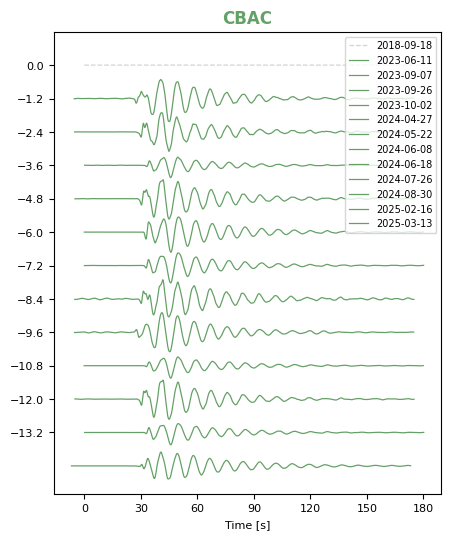

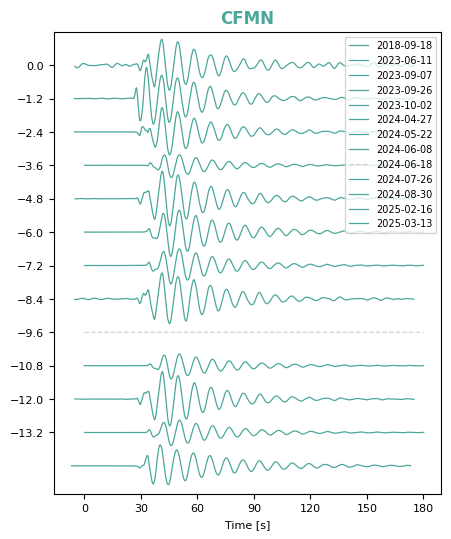

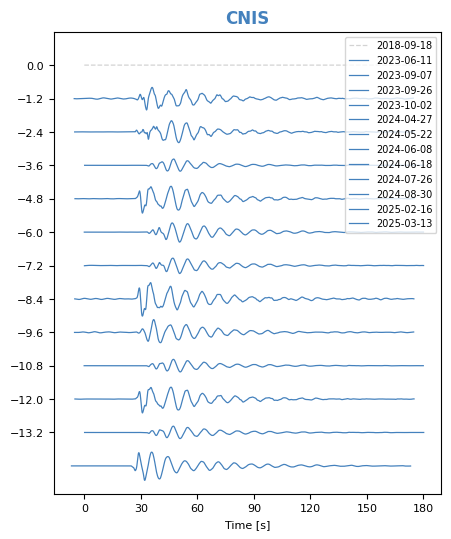

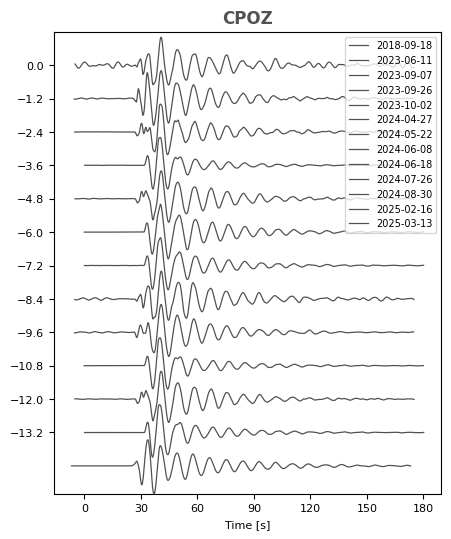

In [ ]:
colors = {key.station: [] for key in stations}
colors['CBAC']='#64A166'
colors['CPOZ']='#515151'
colors['CNIS']='#4481BD'
colors['CFMN']='#4AA79A'

zero_trace=np.zeros(len(ref_tr.ydata))
tax_zero=np.arange(ref_tr.tmin,ref_tr.tmax,ref_tr.deltat) - ref_tr.tmin

for station in dict_traces:
    y_shift=0
    plt.figure(f'{station}',figsize=(5, 6))
    plt.title(f'{station}',color=colors[station],fontweight='bold')
    for ev in dict_traces[station]:
            tr_label=f'{ev[8:12]}-{ev[13:15]}-{ev[16:18]}'
            try:
                trace_plt=dict_traces[station][ev][0]
                tax=np.arange(trace_plt.tmin,trace_plt.tmax,trace_plt.deltat) - ref_tr.tmin
                plt.plot(tax,trace_plt.ydata - y_shift,label=tr_label,color=colors[station],linewidth=0.9)
                y_shift+=1.2
            except:
                plt.plot(tax_zero,zero_trace - y_shift,'--',label=tr_label,color='lightgray',linewidth=0.9)
                y_shift+=1.2
    plt.ylim(-15.4,1.2)
    plt.legend(loc=1,fontsize=7)
    plt.yticks(ticks = list(np.arange(0,-14.4,-1.2)),fontsize=8)
    plt.xticks(ticks = list(np.arange(0,210,30)),fontsize=8)
    plt.xlabel('Time [s]',fontsize=8)
    #
    #plt.savefig(plotdir+f'/{station}_similarity.pdf')